# Credit Repayment Risk Prediction

**Goal**: Build a binary classifier to predict whether a customer will default (Target = 1) or not (Target = 0). The performance of such a model matters a lot because:
1) If a risky customer is predicted as non-default, banks must face financial loss/default risk.
2) If a good customer is predicted as risky, it is unfair, and they lose the opportunity.

Therefore, it is important to improve such systems.

## Table of Contents
1. <a href="#Problem-Framing">Problem Framing</a>
2. <a href="#Data-Overview">Data Overview</a>
3. <a href="#EDA">Exploratory Data Analysis (EDA)</a>
4. <a href="#Preprocessing">Data Preprocessing</a>
5. <a href="#Modeling">Modeling</a>

    5.1. <a href="#LR">Logistic Regression</a>

    5.2. <a href="#DT">Decision Tree</a>

    5.3. <a href="#RF">Random Forest</a>

6. <a href="#Comparison">Comparison</a>
7. <a href="#Interpretation">Interpretation and QAs</a>

First of all, I import the tools I will utilize in the notebook.

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score,
    classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## 1. <a id="Problem-Framing">Problem Framing</a>

In this project, we will interpret the financial behavior of customers in the dataset and use Machine Learning classifiers to predict whether customers are verified for a bank loan at inference time.

## 2. <a id="Data-Overview">Data Overview</a>

In this section, I check:

- dataset shape and column types,
- the distribution of the *Target* variable, and
- missing values

### 2.1. <a id="Overall-Data-Overview">Full Dataset Overview</a>

In the very first step, we read the dataset and display its first rows to gain a basic understanding of the data.

**Note**: In this notebook, the *Target* column is corresponding to the ```repayment_issue``` in the dataset. I also suppose that for this variable in the dataset, ```1``` and ```0``` stand for default and non-default, respectively.

In [ ]:
data_path ="./financial data.csv"
df = pd.read_csv(data_path)

target = "repayment_issue"

df.head()

,monthly_income,avg_monthly_spend,credit_limit,num_transactions,account_tenure_months,cash_withdraw_ratio,late_payment_count,age,region_risk_score,marketing_score,app_login_count,employment_type,debt_to_income,payment_delay_ratio,repayment_issue
0,26867.849400,18963.331725,13797.840243,31,114,0.236576,2,60,0.106796,59.591421,24,self_employed,0.705800,0.062500,1
1,20841.350135,10425.045672,19907.767202,36,64,0.028460,0,20,0.086290,63.392608,16,other,0.500210,0.000000,1
2,28540.385984,9244.744459,23277.396544,45,50,0.330158,0,24,0.438799,62.237803,31,other,0.323918,0.000000,1
3,40506.265408,13339.455402,52088.041939,44,12,0.000000,3,60,0.290462,53.793908,20,self_employed,0.329318,0.066667,1
4,20057.103316,12374.793741,32688.989694,34,107,0.414542,2,39,0.238047,56.238840,12,salaried,0.616978,0.057143,1


Now, it is time to display the dataset's information.

In [ ]:
print(f"\nThe dataset has {df.shape[0]} rows and {df.shape[1]} columns (features).\n")
display(df.info())


The dataset has 1500 rows and 15 columns (features).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   monthly_income         1389 non-null   float64
 1   avg_monthly_spend      1500 non-null   float64
 2   credit_limit           1500 non-null   float64
 3   num_transactions       1500 non-null   int64  
 4   account_tenure_months  1500 non-null   int64  
 5   cash_withdraw_ratio    1500 non-null   float64
 6   late_payment_count     1500 non-null   int64  
 7   age                    1500 non-null   int64  
 8   region_risk_score      1500 non-null   float64
 9   marketing_score        1500 non-null   float64
 10  app_login_count        1500 non-null   int64  
 11  employment_type        1391 non-null   object 
 12  debt_to_income         1500 non-null   float64
 13  payment_delay_ratio    1500 non-null   float64
 14  r

None

Dataset's Information Interpretation:

Our dataset has 1500 rows and 15 columns (including 14 independent variables and 1 dependent variable). All of the variables except for ```monthly_income``` and ```employment_type``` has *no NaN* values. Furthermore, all of the variables, except for ```employment_type```, which has a string type, have numerical values.

In [ ]:
display(df.describe())

,monthly_income,avg_monthly_spend,credit_limit,num_transactions,account_tenure_months,cash_withdraw_ratio,late_payment_count,age,region_risk_score,marketing_score,app_login_count,debt_to_income,payment_delay_ratio,repayment_issue
count,1389.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,24312.409481,14841.587259,28205.612537,34.986667,60.935333,0.247847,1.200667,44.360667,0.281214,50.105322,19.790000,0.698925,0.034366,0.892667
std,10266.222723,7043.868109,10185.056867,5.807665,33.313486,0.143253,1.097210,14.674495,0.155369,14.907166,4.392429,0.406341,0.032900,0.309640
min,6023.917439,3433.102087,9389.324967,18.000000,3.000000,0.000000,0.000000,20.000000,0.003584,-7.845630,5.000000,0.083774,0.000000,0.000000
25%,17140.736774,10037.315102,20795.990431,31.000000,33.000000,0.144665,0.000000,31.000000,0.158645,39.994974,17.000000,0.410565,0.000000,1.000000
50%,22431.662314,13347.461463,26705.461687,35.000000,61.000000,0.245544,1.000000,44.000000,0.261831,49.888985,20.000000,0.604343,0.028571,1.000000
75%,28832.904765,18066.469419,33334.066109,39.000000,88.000000,0.345050,2.000000,57.000000,0.375983,60.087796,23.000000,0.881098,0.054054,1.000000
max,102856.757588,78182.957492,83707.389603,52.000000,119.000000,0.711338,7.000000,69.000000,0.833373,109.134965,37.000000,2.000000,0.260870,1.000000


The table above demonstrates a summary of statistics, including count, std, min, max, mean, and quartiles, for each numerical variable. So, we can easily show how the variables are distributed.

For example, for the ```avg_monthly_spend``` variable, there were 1500 records reported. The min and max of these records are 3433.102087 and 78182.957492, respectively, with a mean of 14841.587259 and std of 7043.868109.

Now, let's build an intuition about how the employment type relates the repayment issues in this dataset.

The count plot below shows that in all employment types, the number of default customers are substantially higher than non-defaults, which indicates that the dataset is highly imbalanced. Most of the people in the dataset are salaried, and therefore, this category has the largest number of repayment issues. "Self-employed" and "other" categories rank second and third in counts, respectively. 

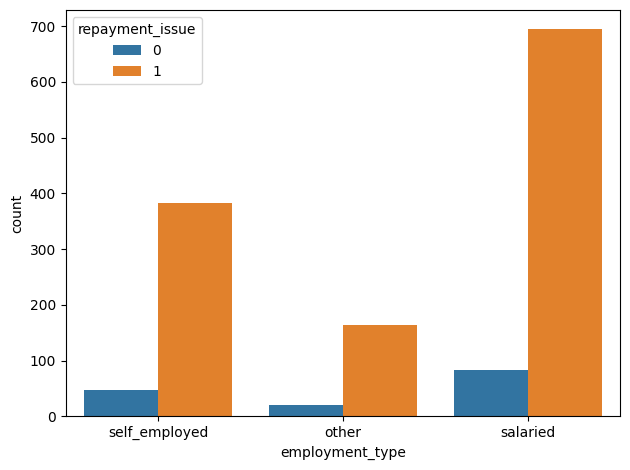

In [ ]:
plt.figure()
sb.countplot(data=df, x='employment_type', hue='repayment_issue')
plt.tight_layout()
plt.show()

### 2.2. <a id="Target-Overview">Target Overview</a>

In [ ]:
target_counts = df[target].value_counts().sort_index()
print(f"\nNumber of each label (0/1) in the Target column in a ascending order:\n\n{target_counts}")


Number of each label (0/1) in the Target column in a ascending order:

repayment_issue
0     161
1    1339
Name: count, dtype: int64


As the table above represents, the dataset has 161 rows with ```repayment_issue``` of 0 (161 non-default customers) and 1339 records with ```repayment_issue``` of 1 (1339 default customers). We can easily conclude that the dataset is imbalanced.

Let's plot the pie chart for the Target variable:

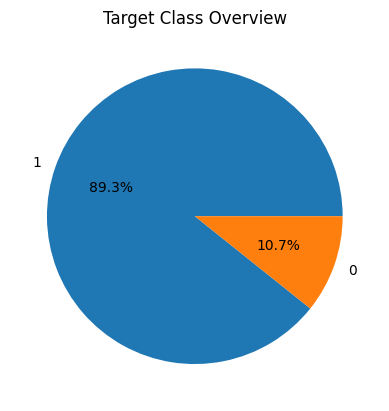

In [ ]:
plt.figure()
plt.pie(df[target].value_counts().values, labels=df[target].value_counts().index, autopct='%1.1f%%')
plt.title("Target Class Overview")
plt.show()

The pie chart above also confirms that the target value is highly imbalanced, which we should balance before training the model.

## 3. <a id="EDA">Exploratory Data Analysis (EDA)</a>

### 3.1. <a id="Most-Related">Most Related Variables to the Target</a>

Regarding the most related variables to the *Target* variable, the best and fastest way is to find the correlation between each variable and the Target. The more the correlation of a variable is, the more it relates to ```repayment_issue```.

**Note**: Correlation is only computed on numerical variables. So, I extract the numerical variables first, and then compute the Pearson correlation, which captures linear relationships between the target and another variable.

In [ ]:
numerical_df = df.drop(columns=[target]).select_dtypes(include="number")
correlations = numerical_df.corrwith(df[target], method="pearson").dropna().sort_values(key=lambda x: x.abs(), ascending=False)

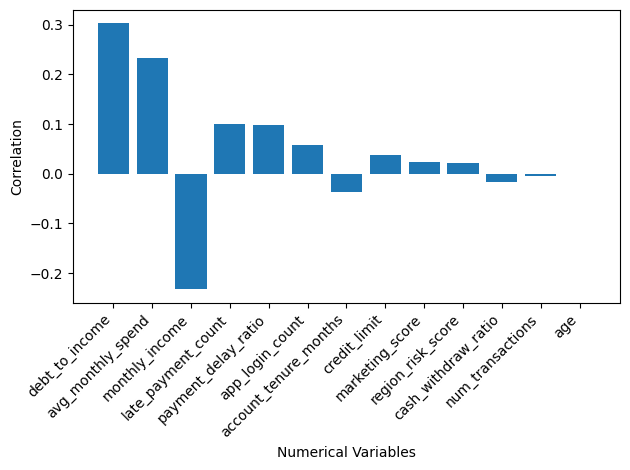

In [ ]:
plt.figure()
plt.bar(correlations.index, correlations.values)
plt.xlabel("Numerical Variables")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

This plot ranks numeric features by their Pearson correlation with ```repayment_issue```. The most related variables to the Target are: ```debt_to_income```, ```avg_monthly_spend```, ```monthly_income```.

The plot shows that ```debt_to_income``` has the strongest positive correlation with ```repayment_issue```, which means people who spend a larger fraction of their income on debt are more likely to have repayment issues. We also see that ```avg_monthly_spend``` has the second strongest positive correlation with the Target. This also means that people who spend more per month on average feel higher financial pressure, which increases repayment risk. Regarding ```monthly_income```, the plot shows that it is negatively correlated to the Target, which means more monthly income reflects fewer repayment issues. Variables related to customers' prior repayment behavior, such as ```late_payment_count``` and ```payment_delay_ratio``` also show positive correlation, which is consistent with credit-risk intuition.

However, what is important about this data is that the correlation values do not reflect causality, and they just represent linear correlation between variables. Therefore, these results are not a final conclusion.

### 3.2. <a id="Missingness">Missingness and Imbalanced Distributions</a>

We have seen that there are two variables with NaN values: ```monthly_income``` and ```employment_type```. Let's compute the number of the missing values of these variables.

In [ ]:
na_count_monthly_income = df["monthly_income"].isna().sum()
na_count_employment_type = df["employment_type"].isna().sum()
na_count_intersection = (df["monthly_income"].isna() & df["employment_type"].isna()).sum()


print(f"\nNumber of records with NaN value in monthly_income: {na_count_monthly_income}")
print(f"\nNumber of records with NaN value in employment_type: {na_count_employment_type}")
print(f"\nNumber of records with NaN value in monthly_income and employment_type: {na_count_intersection}")



Number of records with NaN value in monthly_income: 111

Number of records with NaN value in employment_type: 109

Number of records with NaN value in monthly_income and employment_type: 8


Previously, we saw that all of the variables have no NaN values, except for ```monthly_income```and ```employment_type```, and based on the above counts, we can easily conclude that our dataset contains only **8** records with both ```monthly_income```and ```employment_type``` Nan, and generally, there are only a small portion of records with missing values.

The below distribution plots represent how the three most related features are distributed. It is obvious that all of them are highly right-skewed, with outliers. In such a scenario, mean and std are not good metrics to report, but the median and IQR are. Therefore, for imputation of the missing values for this feature, we should use **median**.

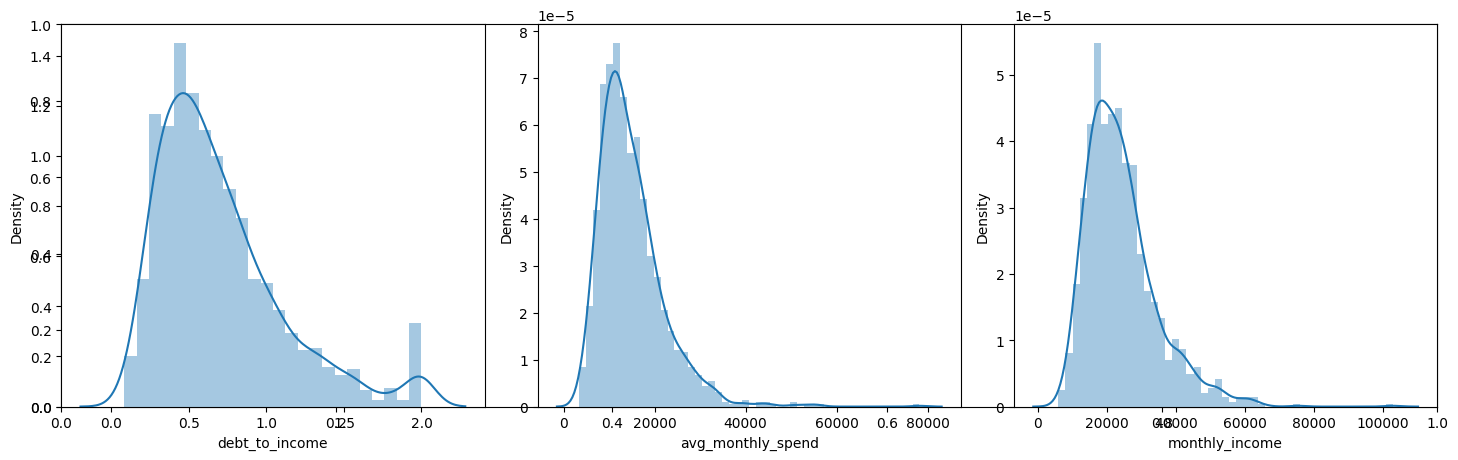

In [ ]:
top_candidate_features = ["debt_to_income", "avg_monthly_spend", "monthly_income"]

plt.subplots(figsize=(15, 5))
for i, col in enumerate(top_candidate_features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

I also want to plot box plots for ```debt_to_income```, ```avg_monthly_spend```, ```monthly_income``` and  to see how their distributions vary between customers with and withput repayment_issues.

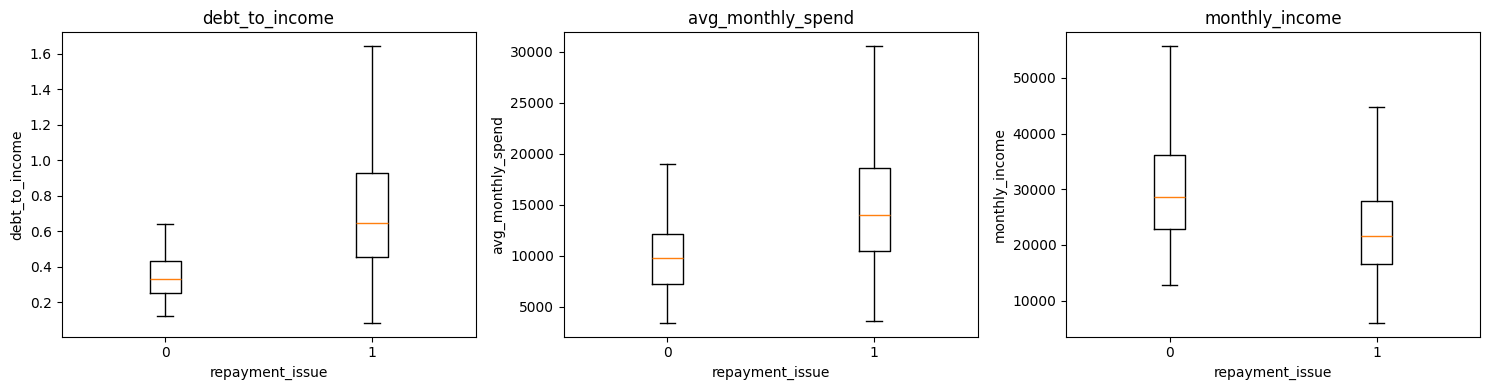

In [ ]:
fig, axes = plt.subplots(1, len(top_candidate_features), figsize=(15,4), sharey=False)

for ax, col in zip(axes, top_candidate_features):
    zeros = df.loc[df[target] == 0, col].dropna()
    ones = df.loc[df[target] == 1, col].dropna()

    ax.boxplot([zeros, ones], labels=["0", "1"], showfliers=False)
    ax.set_title(col)
    ax.set_xlabel(target)
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

Across all three features, the distributions differ significantly between target = 1 and target = 0. Customers with ```repaymet_issue=1``` show lower monthly income, higher average monthly spending, and higher debt-to-income ratio. This seems natural because repayment issues are more likely when income is lower and spending is higher, especially when debt payments consume a larger portion of income.

Also, the distribution and box plots above demonstrate that we have some extreme outliers in the dataset, which might improve the model's performance if they are removed.

## 4. <a id="Preprocessing">Data Preprocessing</a>

### 4.1. <a id="Split Data">Split Data</a>

Split the data into train and test sets, so that the model will test on unseen data during inference. (avoid data leakage)

In [ ]:
SEED = 313

In [ ]:
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print(f"\nNumber of Train samples: {len(X_train)}")
print(f"Number of Test samples:  {len(X_test)}")


Number of Train samples: 1200
Number of Test samples:  300


### 4.2. <a id="Missing-Handling">Missing Value Handling</a>

For handling the missing values in ```employment_type``` and ```monthly_income```, I use these intuitions:

- ```monthly_income```: median

- ```employment_type```: create an explicit "unkonwn" category

In [ ]:
print(f"Number of null records in employment_type: {df['employment_type'].isnull().sum()}")
print(f"Number of null records in monthly_income: {df['monthly_income'].isnull().sum()}")

Number of null records in employment_type: 109
Number of null records in monthly_income: 111


In [ ]:
monthly_income_median = X_train["monthly_income"].median()
X_train["monthly_income"] = X_train["monthly_income"].fillna(monthly_income_median)
X_test["monthly_income"]  = X_test["monthly_income"].fillna(monthly_income_median)

X_train["employment_type"] = X_train["employment_type"].fillna("unknown")
X_test["employment_type"]  = X_test["employment_type"].fillna("unknown")

### 4.3. <a id="Normalization">Normalization</a>

We have 14 numerical features in our dataset, which vary in their range. If I train a model with this raw data, the model may not perform well because it can encounter difficulties in handling these ranges. Therefore, I normalize the numerical features, in which the model can get a better understanding of the data. To do so, I used the following method to transform the distribution of the dataset into Gaussian, with mean of 0 and variance of 1:

\begin{equation*}
x_{new}= \frac{x_{old} - \mu}{\sigma}
\end{equation*}


**Note**: We compute the mean and std for the training set and use them for both the train and test sets. We shouldn't normalize the test samples with the test set's mean and std because it leads to data leakage, which is not desired.

In [ ]:
categorical = [col for col in X.columns if X[col].dtype == "object"]
numerical   = [col for col in X.columns if col not in categorical]

In [ ]:
train_means = X_train[numerical].mean()
train_stds  = X_train[numerical].std(ddof=0).replace(0., 1.)

X_train[numerical] = (X_train[numerical] - train_means) / train_stds
X_test[numerical]  = (X_test[numerical] - train_means)  / train_stds

### 4.4. <a id="Encoding">Encode Categorical Features</a>
```employment_type``` is a categorical variable, but the model only accepts numerical values. Therefore, I have to encode the categories in all the records and convert them into numerical vectors. To do so, I used one-hot encoding, which uses a zero vector of length equal to the number of categories, with only a 1 in the corresponding category.

In [ ]:
X_train_one_hot = pd.get_dummies(X_train, columns=categorical, drop_first=False)
X_test_one_hot  = pd.get_dummies(X_test, columns=categorical, drop_first=False)

Here is how the train samples look like after one-hot encoding:

In [ ]:
X_train_one_hot.head()

,monthly_income,avg_monthly_spend,credit_limit,num_transactions,account_tenure_months,cash_withdraw_ratio,late_payment_count,age,region_risk_score,marketing_score,app_login_count,debt_to_income,payment_delay_ratio,employment_type_other,employment_type_salaried,employment_type_self_employed,employment_type_unknown
1317,-0.479287,0.119406,1.153141,1.692383,-1.354109,0.302102,-0.194856,1.198689,-0.840628,-0.694961,0.017248,0.250224,-0.393830,False,False,True,False
1368,-0.588224,0.292072,-0.670658,-0.518586,1.505042,-1.736309,-0.194856,-1.105396,-0.284895,2.246158,-0.210200,0.522032,-0.135477,False,False,True,False
351,1.626497,2.084495,-0.415009,0.161713,0.090515,-1.736309,0.704481,1.401991,-1.282698,1.664246,0.699594,0.100964,0.581037,False,True,False,False
246,-0.612371,0.817576,0.319753,0.501862,-1.384205,0.452211,-0.194856,-1.037629,-0.996525,0.068778,-1.802340,1.045507,-0.276119,False,False,True,False
370,-0.193414,-0.959626,-0.189629,-0.858735,0.421574,-0.763882,-0.194856,-0.224422,2.645941,2.176724,-0.892546,-0.824197,-0.076498,False,True,False,False


In [ ]:
print("Final shapes:", X_train_one_hot.shape, X_test_one_hot.shape)

Final shapes: (1200, 17) (300, 17)


4 columns corresponding to each employment type are replaced with the ```employment_type``` column. Hence, the one-hot encoded training set contains 17 columns instead of 14.

### 4.5. <a id="imbalance">Imbalanced Dataset Handling</a>

For handling imbalanced dataset issue, I tested two methods:
1) set ```class_weight="balanced"``` for each classifier. This will weight classes to balance the dataset.
2) Use ```RandomOverSampler``` which balances an imbalanced dataset by randomly duplicating samples from the minority class until the classes have similar sizes.

The results of both experiments were almost the same, and the models trained on a balanced dataset. IN this notebook, only the second experiment is written.


In [ ]:
ros = RandomOverSampler(sampling_strategy='minority', 
						random_state=SEED) 

X_train_res, y_train_res = ros.fit_resample(X_train_one_hot, y_train) 

print(f"Number of training samples in the balanced dataset: {X_train_res.shape[0]}\nNumber of training samples in the imbalanced dataset:{X_train_one_hot.shape[0]}")

Number of training samples in the balanced dataset: 2142
Number of training samples in the imbalanced dataset:1200


## 5. <a id="Modeling">Modeling</a>

I will use three different classifiers to predict whether customers are default or not.

5.1. <a href="#LR">Logistic Regression</a>

5.2. <a href="#DT">Decision Tree</a>

5.3. <a href="#RF">Random Forest</a>

After training each classifier, I will evaluate each seperately. For evaluation, I will use the follwoing metrics:

- Accuracy:
  \begin{equation*}
  \frac{TP + TN}{TP+TN+FP+FN}
  \end{equation*}

- Balanced Accuracy: the average of recall obtained on each class.
\begin{equation*}
Balanced \;\; Accuracy = \frac{TPR + TNR}{2}
\end{equation*}
where 

\begin{equation*}
TPR = \frac{TP}{TP+FN}, \;\; TNR=\frac{TN}{TN + FP}
\end{equation*}

- ROC-AUC (Receiver Operating Characteristic-Area Under the Curve): represents how well a binary classification model works. AUC is the area under the ROC curve, and the more this area is, the better model performs in the classification task. As represented in the below image, ROC curve shows True Positive Rate againts False Positive rate across all possible decision thresholds.
<p align="center">
  <img src="AUC-ROC-Curve.webp" width="500">
</p>

In [ ]:
def display_metrics(y_test, y_pred, proba):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}\n")
    print(f"ROC-AUC: {roc_auc_score(y_test, proba):.3f}\n")
    print(f"Classification report:\n {classification_report(y_test, y_pred, digits=3)}")
    return

def plot_ROC(clf, X_test, y_test, clf_name):
    plt.figure()
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title(f"ROC curve ({clf_name})")
    plt.show()
    return

def plot_confusion_matrix(y_test, y_pred, clf_name):
    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion matrix ({clf_name})")
    plt.show()
    return

### 5.1. <a id="LR">Logistic Regression</a>
In this section, I want to train a Logistice Regression classifier and evaluate it to see how well it performs in predicting customers' repayment issue.


#### 5.1.1. <a id="LR-Train">Train</a>

I used scikit-learn's LogisticRegression which takes the following parameters:

- **max_iter**: maximum number of iterations taken for the solvers to converge.

- **slover**: the algorithm for solving the optimization problem. For a binary classifier, ```lbfgs``` performs reasonably well.

- **penalty**: Specifies the norm penalty used in regularization.

- **C**: The inverse of regularization strength. Smaller values specify stronger regularization.

In [ ]:
LR = LogisticRegression(max_iter=2000, solver="lbfgs", penalty="l2", C=1, random_state=SEED)

LR.fit(X_train_res, y_train_res)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",313
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` pr

#### 5.1.2. <a id="LR-Eval">Evaluation</a>

In [ ]:
proba = LR.predict_proba(X_test_one_hot)[:, 1]
y_pred = LR.predict(X_test_one_hot)

display_metrics(y_test, y_pred, proba)

Accuracy: 0.733

Balanced Accuracy: 0.796

ROC-AUC: 0.854

Classification report:
               precision    recall  f1-score   support

           0      0.269     0.875     0.412        32
           1      0.980     0.716     0.828       268

    accuracy                          0.733       300
   macro avg      0.624     0.796     0.620       300
weighted avg      0.904     0.733     0.783       300



```Accuracy``` of 0.73 means that $73\%$ of predictions are correct at the 0.5 threshold. But accuracy alone is not enough to judge quality, and since oversampling changes class prevalence during training, the 0.5 threshold may not be optimal. ```Balanaced_accuracy``` of nearly 0.80 means that on average, the model peroforms well in predicting both classes. As the original test datset is imbalanced (32 samples belong to class ```0``` and 268 samples belong to class ```1```), it is important to report ```ROC-AUC``` as well. This metric shows how well the classifier separates the two classes across all thresholds. We got an ```ROC-AUC``` of $0.854$ which represents that the model performs well in seperating both classes.

<Figure size 640x480 with 0 Axes>

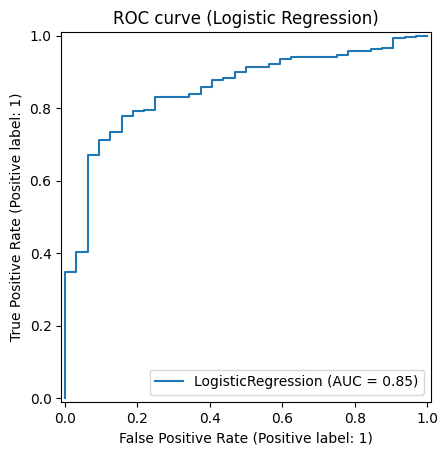

In [ ]:
plot_ROC(LR, X_test_one_hot, y_test, "Logistic Regression")

From the ROC curve above, we can conclude that with an AUC of nearly $0.85$, the model predicts the two classes well.

<Figure size 640x480 with 0 Axes>

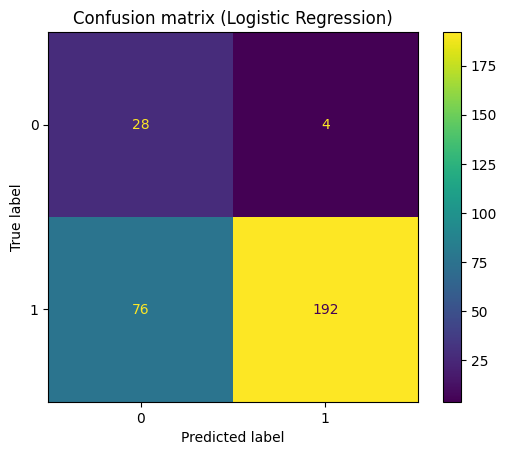

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Logistic Regression")

The confusion matrix above shows that out of 32 samples belong to class 0, the classifier predicts 28 of them correctly, and it fails to predict 76 of 268 samples in the class 1 correctly.

### 5.2. <a id="DT">Decision Tree</a>

In tis section, I want to train a Decision Tree classifier and evaluate it to see how well it performs in predicting customers' repayment issue.


#### 5.2.1 <a id="DT-Train">Train</a>

Let's have a look at the parameters used for this classifier:

- **criterion**: The function to measure the quality of a split. Used ```gini``` to calculate the information gain, which measures how "mixed" or "impure" a group of data is. 
\begin{equation*}
Gini\;\; Impurity = 1 - \sum((p_i)^2)
\end{equation*}
Considering the above defenition, the lower the gini is, the purer the node is. For example, consider a situation that $p_0 = 0.2$ and $p_1 = 0.8$ in a node. Then, the gini score for this node would be $0.32$. In another node, $p_0 = 0.5$ and $p_1 = 0.5$, with gini score of $0.5$. In the first node, the model with a more certainty choses class 1 ($p_1 = 0.8$), but in the second node, it is uncertain ($p_1 = 0.5$).

- **splitter**: The strategy used to choose the split at each node. ```best``` chooses the best split.
- **max_depth**: The maximum depth of the tree.
- **min_samples_leaf**: The minimum number of samples required to split an internal node.


In [ ]:
DT = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=5, min_samples_leaf=20, random_state=SEED)
DT.fit(X_train_res, y_train_res)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",20
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",313
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current 

#### 5.2.2. <a id="DT-Eval">Evaluation</a>

In [ ]:
proba = DT.predict_proba(X_test_one_hot)[:, 1]
y_pred = DT.predict(X_test_one_hot)

display_metrics(y_test, y_pred, proba)

Accuracy: 0.697

Balanced Accuracy: 0.803

ROC-AUC: 0.850

Classification report:
               precision    recall  f1-score   support

           0      0.252     0.938     0.397        32
           1      0.989     0.668     0.797       268

    accuracy                          0.697       300
   macro avg      0.621     0.803     0.597       300
weighted avg      0.910     0.697     0.755       300



Accuracy of $0.70$ means that the model predict $70\%$ of all samples right. But accuracy alone is not enough to judge quality, and since oversampling changes class prevalence during training, the 0.5 threshold may not be optimal. Balanaced Accuracy of nearly 0.8 means that on average, the model peroforms well in predicting both classes. We also got an ROC-AUC of $0.85$ which represents that the model performs well in seperating both classes.

<Figure size 640x480 with 0 Axes>

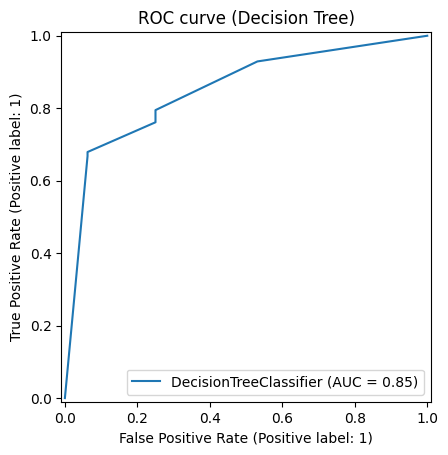

In [ ]:
plot_ROC(DT, X_test_one_hot, y_test, "Decision Tree")

<Figure size 640x480 with 0 Axes>

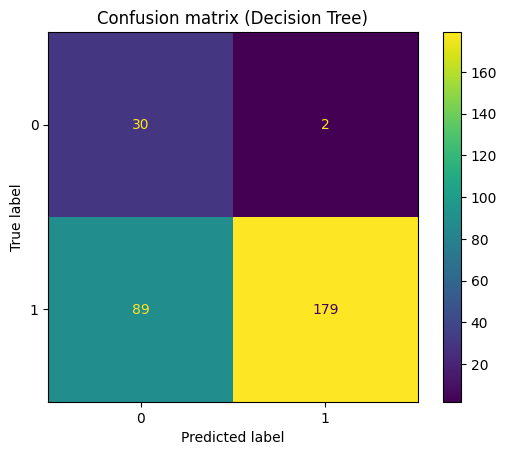

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Decision Tree")

This confusion matrix says that while the decision tree classifier predicts only 2 of the test samples belonging to class ```0``` incorrect, it estimates nearly 90 out of 268 default customers as non-default.

### 5.3. <a id="RF">Random Forest</a>

In tis section, I want to train a Random Forest classifier and evaluate it to see how well it performs in predicting customers' repayment issue. 

#### 5.3.1. Train

Let's have a look at the parameters used for this classifier:
- **n_estimators**: The number of trees in the forest.

- **criterion**: Same as the Decision Tree.

- **max_depth**: Same as the Decision Tree.

- **min_samples_leaf**: Same as the Decision Tree.

- **min_samples_split**: The minimum number of samples required to split an internal node.

- **max_features**: The number of features to consider when looking for the best split. ```sqrt``` means: max_features=sqrt(n_features).

- **bootstrap**: Whether bootstrap samples are used when building trees.

In [ ]:
RF = RandomForestClassifier(
    n_estimators=400, max_depth=10, min_samples_leaf=10, min_samples_split=5,
    max_features="sqrt", bootstrap=True, random_state=SEED)
RF.fit(X_train_res, y_train_res)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [ ]:
proba = RF.predict_proba(X_test_one_hot)[:, 1]
y_pred = RF.predict(X_test_one_hot)

display_metrics(y_test, y_pred, proba)

Accuracy: 0.827

Balanced Accuracy: 0.834

ROC-AUC: 0.884

Classification report:
               precision    recall  f1-score   support

           0      0.365     0.844     0.509        32
           1      0.978     0.825     0.895       268

    accuracy                          0.827       300
   macro avg      0.671     0.834     0.702       300
weighted avg      0.912     0.827     0.854       300



Accuracy of 0.82 means that the model predict $82\%$ of all samples right. But accuracy alone is not enough to judge quality, and since oversampling changes class prevalence during training, the 0.5 threshold may not be optimal. Balanaced Accuracy of nearly $0.83$ means that on average, the model peroforms well in predicting both classes. The ROC-AUC of $0.88$ represents that the model performs well in seperating both classes.

**Note**: Before balancing the dataset, the AUC for this classifier was $87\%$ and it increased $1\%$ after balancing the dataset.

<Figure size 640x480 with 0 Axes>

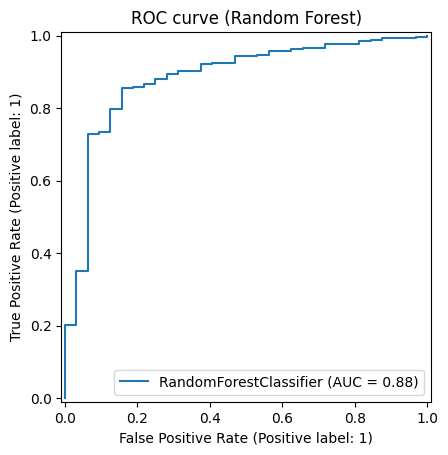

In [ ]:
plot_ROC(RF, X_test_one_hot, y_test, "Random Forest")

<Figure size 640x480 with 0 Axes>

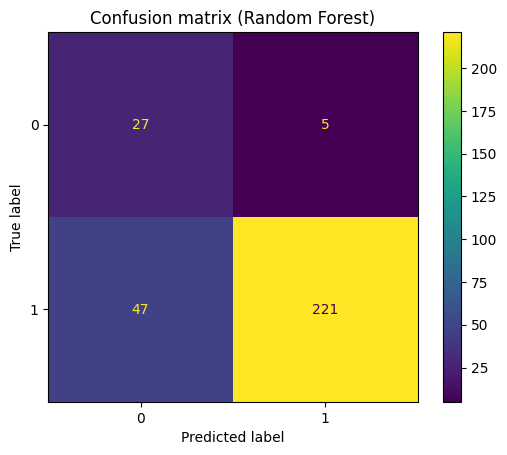

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Random Forest")

The confusion matrix above shows that the random forest classifier predicts 47 sampels of class ```1``` and only 5 samples of class ```0``` wrongly.

## 6. <a id="Comparison">Comparison</a>

By comparing all of the three classifiers above, we can conclude that:

- Recall for class ```0``` for all three classifiers is in the range of $80-90\%$, which means the models correctly finds almost all of true ```0``` cases.

- Recall for class ```1``` for all three classifiers is in the rage of $70-80\%$, which means the models correctly finds most of true ```1``` cases.

- Precision for class ```0``` for all three classifiers is nearly $20-40\%$, which means that $60-80\%$ of ```0``` predictions are actually ```1```, and they are predicted incorrect.

- Precision for class ```1``` for all three classifiers is nearly $98\%$, which means that when the models predicts ```1```, it is correct almost all the time.

- Random Forest is the best among the tested classifiers, with an AUC of $0.88$ and balanced accuracy of $0.834$.

- Overall, random forest predicts only 52 samples incorrect (47 FN and 5 FP), while the other two predcit more than 70 samples wrongly.


Therefor, Random Forest is the best choice in this context.

## 7. <a id="Interpretation">Interpretation and QAs</a>

### 7.1. What has the model learned overall?
The model has learned to estimate ```repayment_issue``` based on the customers' financial information, which indicates that a higher debt-to-income and monthly spending are directly affect a repayment issue. This is while a higher monthly income lowers the rist of a repayment issue. Overall, the random forest classifier seperates classes reasonably good with and ROC-AUC of nearly $0.88$.

### 7.2. Under what conditions might this model make wrong decisions?
1) Having an imbalanced dataset, the model can be biased toward the majority class. In our results, although the model predicts class 0 with high recall, it has low precision for class 0, which means a lot of predicted non-default customers have actually repayment issues.

2) When the two classes overlap in features, the model fails in seperating them perfectly. In other words, the model makes errors when someone is not a typical high-rist or low-risk customer. 

### 7.3. What would I improve if I had more time or data?
1) Remove outliers of the most target-related features from the dataset and repeate the classification. This might imrove the classifiers' prerformance.
2) Modify the models to lower the number of false positives and false negatives to improve their performance.
3) Tune the classification threshold to find the best one.
4) Design a neural network/deep learning model to solve the prediction problem, which may improve class separation.
5) Use k-fold cross-validation to improve the model's performance, especially if I have more data.
6) Collect more data and study more about the features in the dataset to engineer the features and extract more information from the customer's behavior. Possibly, combine different features to build new integrated, more informative ones.